# SVM implementation to test transfer learning

The notebook implement the paper:

### Facial expression recognition based on fusion feature of PCA and LBP with SVM

@article{luo2013facial,
  title={Facial expression recognition based on fusion feature of PCA and LBP with SVM},
  author={Luo, Yuan and Wu, Cai-ming and Zhang, Yi},
  journal={Optik-International Journal for Light and Electron Optics},
  volume={124},
  number={17},
  pages={2767--2770},
  year={2013},
  publisher={Elsevier}
}

### Import librairies

In [2]:
from utils.load_config import load_config
from utils.load_data import load_data
from plots_utils.plot_BVS import display_image
from plots_utils.plot_BVS import display_images

import numpy as np
import cv2
from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import PCA
import tqdm

import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

### import data

In [3]:
# define configuration
config_path = 'SVM_t03_SVM_LBP_BVS_m0001.json'

# load config
config = load_config(config_path, path='../../configs/SVM')

# load all ref frames
config['train_avatar'] = "all_identities"
config['train_expression'] = ["Neutral"]
ref_data = load_data(config, get_raw=True)
# load all expressions on louise
config['train_avatar'] = "Louise"
config['train_expression'] = ["all_expressions"]  # don't load the neutral expression (!= 'full') since it's already in ref_data
louise_expr_data = load_data(config, get_raw=True)

print("[LOAD] shape ref_data", np.shape(ref_data[0]))
print("[LOAD] shape louise_expr_data", np.shape(louise_expr_data[0]))
train_data = [np.vstack((ref_data[0], louise_expr_data[0])), np.concatenate((ref_data[1], louise_expr_data[1]))]
print("[LOAD] shape train_data[0]", np.shape(train_data[0]))
print("[LOAD] shape train_data[1]", np.shape(train_data[1]))
n_training = len(train_data[0])
print("[LOAD] n_training data", n_training)

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:443: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 15/15 [00:00<00:00, 146.58it/s]
/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:443: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 6/6 [00:00<00:00, 145.85it/s]

[LOAD] shape ref_data (15, 224, 224, 3)
[LOAD] shape louise_expr_data (6, 224, 224, 3)
[LOAD] shape train_data[0] (21, 224, 224, 3)
[LOAD] shape train_data[1] (21,)
[LOAD] n_training data 21


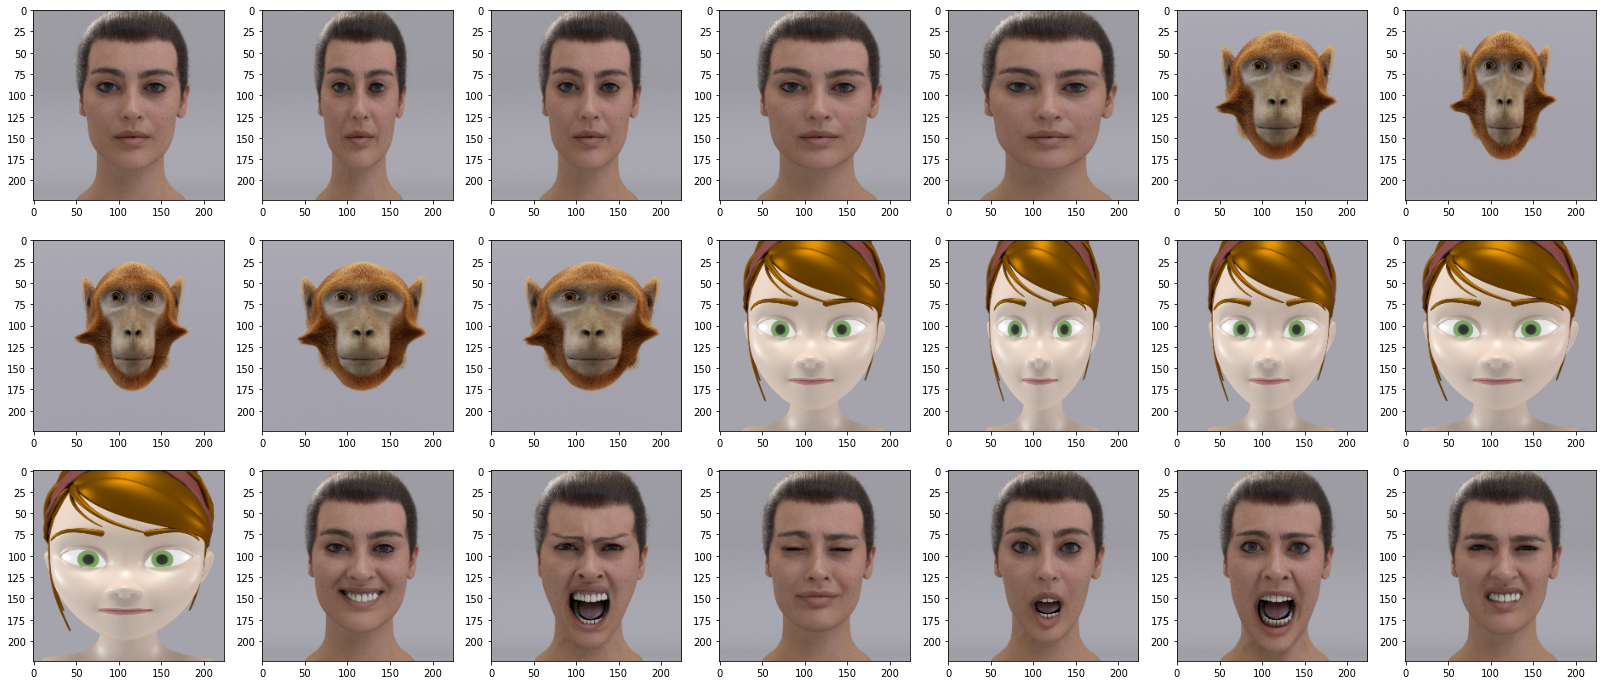

In [4]:
display_images(train_data[0])

## Image pre-processing
We only require to change the image to black and white since BVS has same brightness and centered face

In [5]:
def transform_images_to_BnW(data, verbose=False):
    bw_images = []
    for image in data:
        image = np.array(image).astype(np.uint8)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        bw_images.append(255 - gray)

    if verbose:
        print("min max gray", np.amin(bw_images), np.amax(bw_images))
        print("shape bw_train_data", np.shape(bw_images))
    return bw_images

In [6]:
bw_train_images = transform_images_to_BnW(train_data[0], verbose=True)

min max gray 0 255
shape bw_train_data (21, 224, 224)


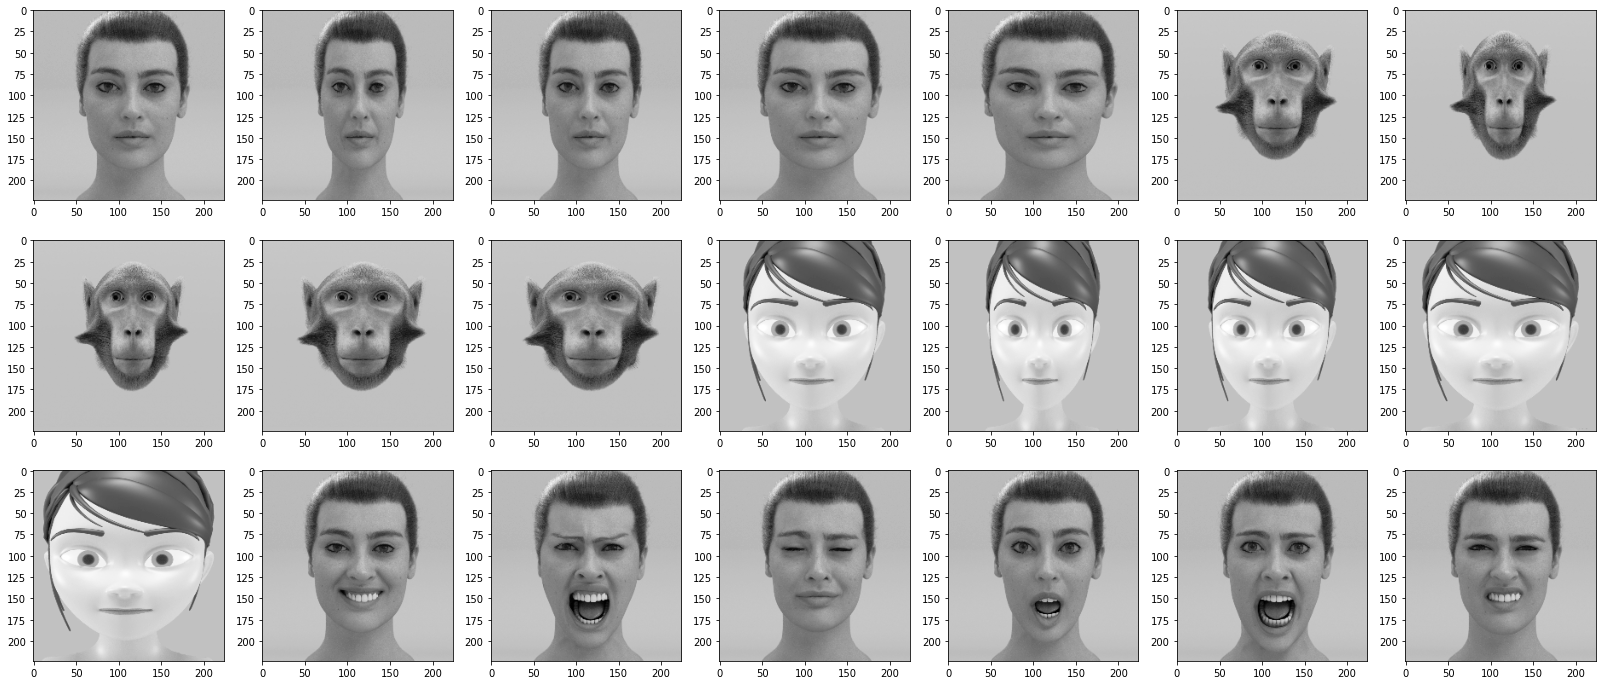

In [7]:
display_images(bw_train_images, is_black_n_white=True)

### compute LBP

In [8]:
def compute_LBP(image):
    h, w = image.shape
    lbp_image_score = np.zeros(np.shape(image))

    # create lbp weights
    weights = [2**i for i in range(8)]

    for i in range(1, h-1):
        for j in range(1, w-1):
            gray_scale = image[i, j]
            patch = [image[i-1, j-1], image[i-1, j], image[i-1, j+1], image[i, j+1], image[i+1, j+1], image[i+1, j], image[i+1, j-1], image[i, j-1]]
            threshold = np.array(patch).astype(int) - gray_scale
            # apply s(x)
            threshold[threshold <= 0] = 0
            threshold[threshold > 0] = 1

            # compute lbp score
            lbp_image_score[i, j] = np.sum(threshold * weights)


    return lbp_image_score

In [9]:
lbp_images = []
for i in tqdm.tqdm(range(n_training)):
    lbp_images.append(compute_LBP(bw_train_images[i]))
lbp_images = np.array(lbp_images)
print("shape lbp_images", np.shape(lbp_images))

100%|██████████| 21/21 [00:08<00:00,  2.57it/s]

shape lbp_images (21, 224, 224)


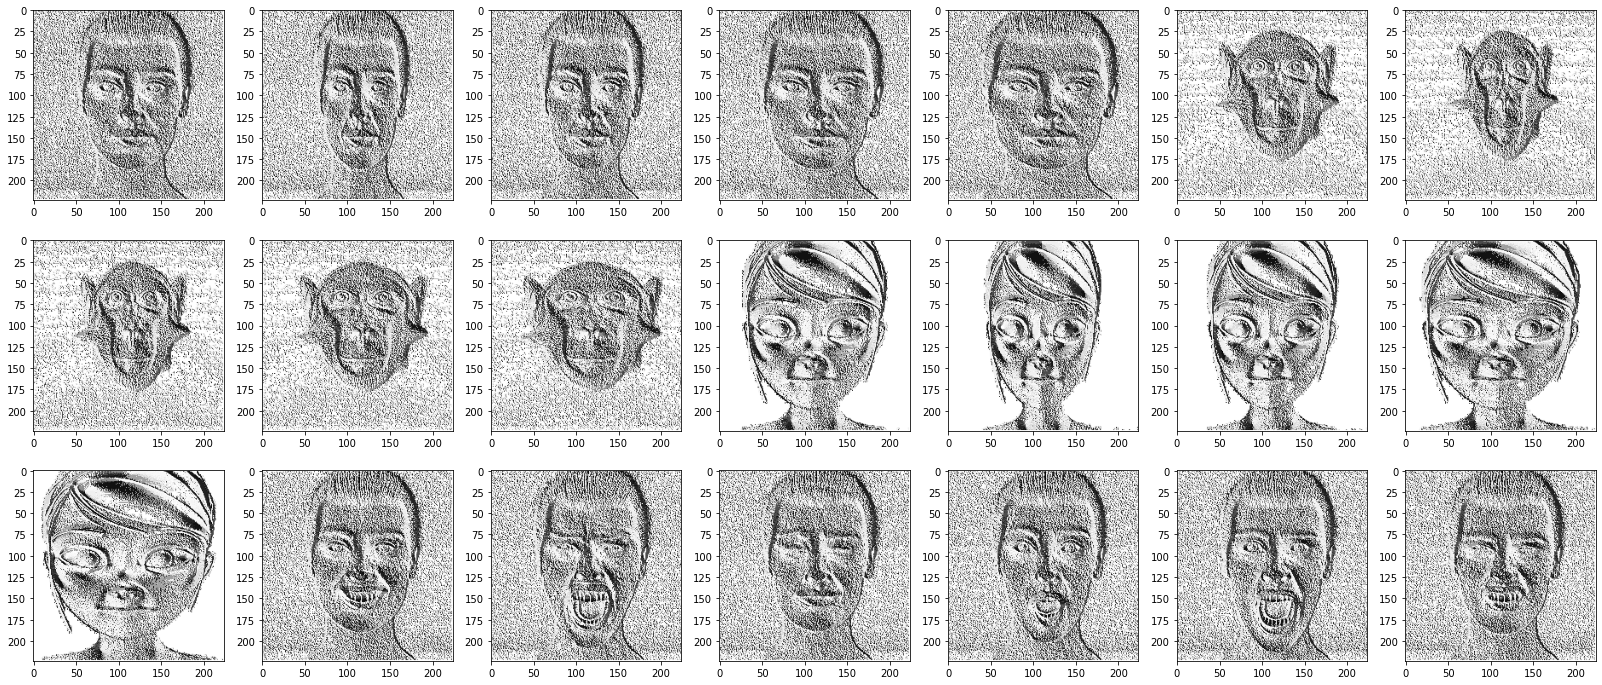

In [10]:
# display lbp images
display_images(lbp_images / np.amax(lbp_images) * 255, is_black_n_white=True)

In [11]:
# construct local mouth feature
lbp_mouth_region = lbp_images[:, 120:200, 63:163]
print("lbp_mouth_region", np.shape(lbp_mouth_region))

lbp_mouth_region (21, 80, 100)


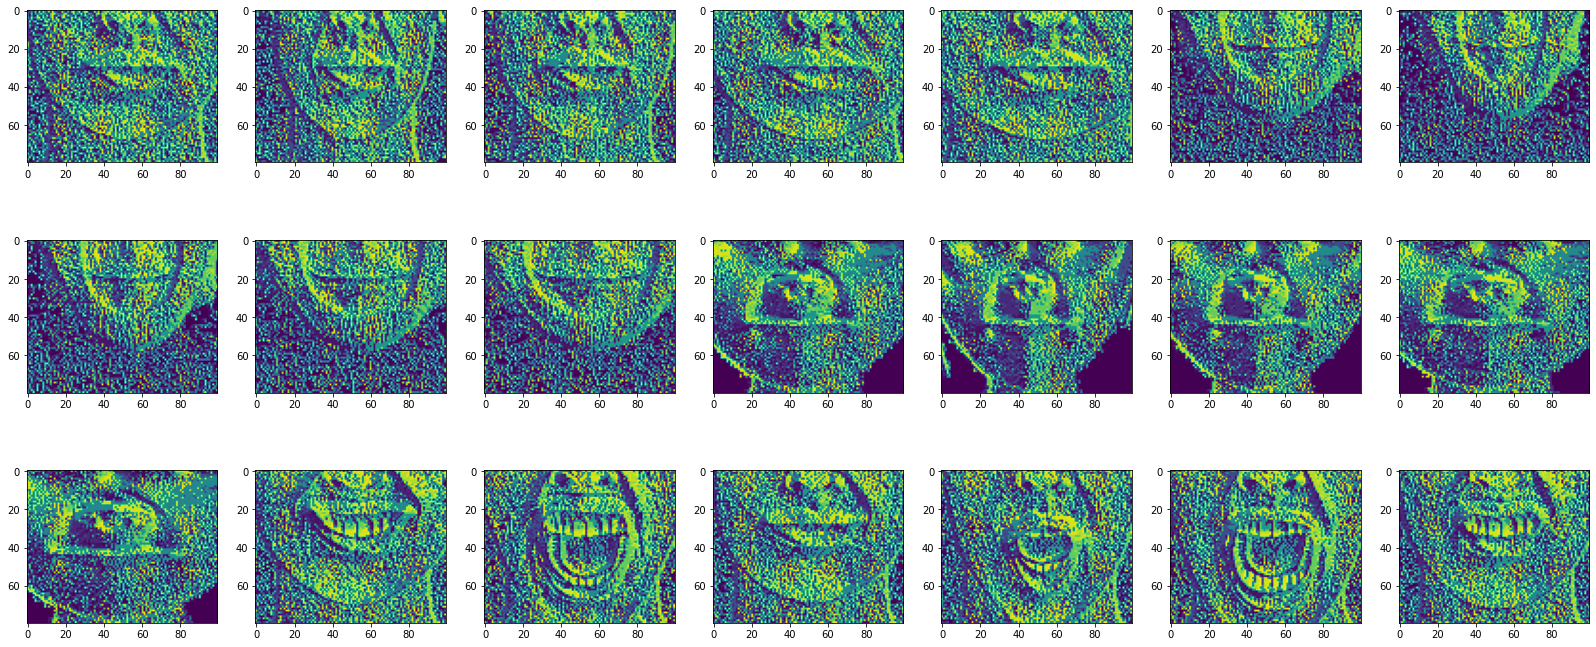

In [12]:
display_images(lbp_mouth_region)

## Compute global features with PCA

In [13]:
def norm_and_combine_local_n_global_features(glob_features, loc_features, verbose=False):
    # first normalize both local and global feature
    norm_glob = glob_features / np.amax(glob_features)
    norm_glob = np.reshape(norm_glob, (len(norm_glob), -1))
    norm_loc = loc_features / np.amax(loc_features)
    norm_loc = np.reshape(norm_loc, (len(norm_loc), -1))

    # concatenate both local and global feature
    features = np.concatenate((norm_glob, norm_loc), axis=1)

    if verbose:
        print("min/max glob_features", np.amin(glob_features), np.amax(glob_features))
        print("shape norm_glob", np.shape(norm_glob))
        print("min/max loc_features", np.amin(loc_features), np.amax(loc_features))
        print("shape norm_loc", np.shape(norm_loc))
        print("shape features", np.shape(features))

    return features

In [14]:
train_images = norm_and_combine_local_n_global_features(bw_train_images, lbp_mouth_region, verbose=True)

min/max glob_features 0 255
shape norm_glob (21, 50176)
min/max loc_features 0.0 255.0
shape norm_loc (21, 8000)
shape features (21, 58176)


In [15]:
# apply PCA
pca = PCA(n_components=20)
transformed_train_images = pca.fit_transform(train_images)
print("shape pca_train", np.shape(transformed_train_images))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

shape pca_train (21, 20)
[0.275 0.178 0.054 0.052 0.045 0.035 0.034 0.031 0.03  0.028 0.027 0.026 0.025 0.025 0.024 0.024 0.023 0.022 0.021 0.02 ]
[98.619 79.341 43.571 42.787 39.709 35.2   34.615 33.285 32.824 31.467 31.003 30.346 29.892 29.471 29.342 29.099 28.649 27.67  27.255 26.721]


## Apply SVM

In [16]:
cls = svm.SVC(gamma=0.0001, C=100)

### training

In [17]:
sample_weight = np.ones(len(train_images))
sample_weight[15:] = 15
cls.fit(transformed_train_images, train_data[1], sample_weight=sample_weight)

SVC(C=100, gamma=0.0001)

# Predict Images

### load data

In [18]:
test_data = load_data(config, train=False, get_raw=True)
test_data = [test_data[0][7:], test_data[1][7:]]
print("shape test_data[0]", np.shape(test_data[0]))

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:443: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 105/105 [00:00<00:00, 152.79it/s]

shape test_data[0] (98, 224, 224, 3)


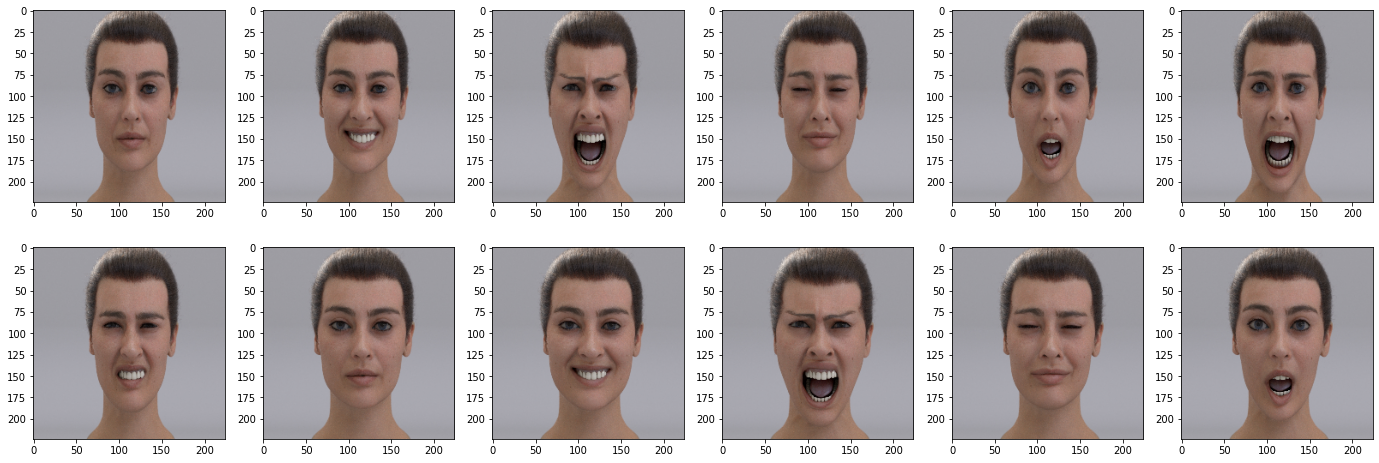

In [19]:
display_images(test_data[0][:12], n_max_col=6)

### apply feature extraction

In [20]:
def apply_feature_extraction(images, pca=None, mouth_region=((120, 200), (63, 163))):
    bw_images = transform_images_to_BnW(images)

    lbp_images = []
    for i in tqdm.tqdm(range(len(bw_images))):
        lbp_images.append(compute_LBP(bw_images[i]))
    lbp_images = np.array(lbp_images)

    # construct local mouth feature
    lbp_mouth_region = lbp_images[:, mouth_region[0][0]:mouth_region[0][1], mouth_region[1][0]:mouth_region[1][1]]

    # combine both features
    features = norm_and_combine_local_n_global_features(bw_images, lbp_mouth_region)

    # transform with pca
    if pca is None:
        return features
    else:
        return pca.transform(features)

In [21]:
test_feature = apply_feature_extraction(test_data[0], pca)
print("shape test_feature", np.shape(test_feature))

100%|██████████| 98/98 [00:38<00:00,  2.57it/s]

shape test_feature (98, 20)


### Predict images

In [22]:
preds = cls.predict(test_feature)
print("accuracy:", metrics.accuracy_score(test_data[1], y_pred=preds))
print(metrics.classification_report(test_data[1], y_pred=preds))

accuracy: 0.14285714285714285
              precision    recall  f1-score   support

         0.0       0.14      1.00      0.25        14
         1.0       0.00      0.00      0.00        14
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        14
         4.0       0.00      0.00      0.00        14
         5.0       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        14

    accuracy                           0.14        98
   macro avg       0.02      0.14      0.04        98
weighted avg       0.02      0.14      0.04        98



/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [23]:
for i in range(len(test_data[1])):
    print("image {}, y_pred {}, prediction: {}".format(i, test_data[1][i], preds[i]))

image 0, y_pred 0.0, prediction: 0.0
image 1, y_pred 1.0, prediction: 0.0
image 2, y_pred 2.0, prediction: 0.0
image 3, y_pred 3.0, prediction: 0.0
image 4, y_pred 4.0, prediction: 0.0
image 5, y_pred 5.0, prediction: 0.0
image 6, y_pred 6.0, prediction: 0.0
image 7, y_pred 0.0, prediction: 0.0
image 8, y_pred 1.0, prediction: 0.0
image 9, y_pred 2.0, prediction: 0.0
image 10, y_pred 3.0, prediction: 0.0
image 11, y_pred 4.0, prediction: 0.0
image 12, y_pred 5.0, prediction: 0.0
image 13, y_pred 6.0, prediction: 0.0
image 14, y_pred 0.0, prediction: 0.0
image 15, y_pred 1.0, prediction: 0.0
image 16, y_pred 2.0, prediction: 0.0
image 17, y_pred 3.0, prediction: 0.0
image 18, y_pred 4.0, prediction: 0.0
image 19, y_pred 5.0, prediction: 0.0
image 20, y_pred 6.0, prediction: 0.0
image 21, y_pred 0.0, prediction: 0.0
image 22, y_pred 1.0, prediction: 0.0
image 23, y_pred 2.0, prediction: 0.0
image 24, y_pred 3.0, prediction: 0.0
image 25, y_pred 4.0, prediction: 0.0
image 26, y_pred 5.0, 

# Test with no PCA

In [24]:
cls2 = svm.SVC(gamma=0.0001, C=100)
print("shape train_images", np.shape(train_images))
sample_weight = np.ones(len(train_images))
sample_weight[15:] = 15
cls2.fit(train_images, train_data[1], sample_weight=sample_weight)

shape train_images (21, 58176)


SVC(C=100, gamma=0.0001)

In [25]:
test_feature_no_pca = apply_feature_extraction(test_data[0])

100%|██████████| 98/98 [00:37<00:00,  2.61it/s]


In [26]:
preds = cls2.predict(test_feature_no_pca)
print("accuracy:", metrics.accuracy_score(test_data[1], y_pred=preds))
print(metrics.classification_report(test_data[1], y_pred=preds))

accuracy: 0.14285714285714285
              precision    recall  f1-score   support

         0.0       0.14      1.00      0.25        14
         1.0       0.00      0.00      0.00        14
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        14
         4.0       0.00      0.00      0.00        14
         5.0       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        14

    accuracy                           0.14        98
   macro avg       0.02      0.14      0.04        98
weighted avg       0.02      0.14      0.04        98



/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av